<a href="https://colab.research.google.com/github/SusmitWani/NNFL-Course-Fall-2020/blob/master/Neural_Network_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
'''
Major part of the code is adapted from the below mentioned URL
https://github.com/yenpinchiu/OO-Neural-Network/blob/master/back_propagation.py
for stochastic learning
More functions were added to the code for batch learning
'''

import numpy as np
import pandas as pd
import math
import random
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

%matplotlib inline

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def sigmoid(z):
    '''
    Returns the sigmoid of passed value
    
    sigmoid(z) = 1 / (1 + e ^ (-z))
    '''
    return 1 / (1 + math.exp(-z))

In [ ]:
class edge:
    '''
    Edge is defined as weighted connection
    between two nodes (perceptrons), one belonging to one layer and
    the other belonging to the next layer

    weight:     weight value of the edge
    dw:         to store and add 𝛿(cost)/𝛿(w) for each training example in batch method 
    from_node:  the node (perceptron) from which this edge is orginated
    to_node:    the node (perceptron) to which it is connected
    '''

    def __init__(self):
        self.weight = None
        self.dw = None
        self.from_node = None
        self.to_node = None

In [ ]:
class node:
    '''
    Node (or Perceptron)

    value:      the output given out by the node after activation
    delta:      𝛿(cost)/𝛿(value)
    in_edge:    list of edges that are connected to this node from previous layer
    out_edge:   list of edges that are originated from this node
    bias:       the bias term associated with this node
    db:         to store and add 𝛿(cost)/𝛿(b) for each training example in batch method 
    '''

    def __init__(self):

        self.value = None
        self.delta = None
        self.db = None
        self.in_edge = []
        self.out_edge = []
        self.bias = None

    def build_in_edge(self, linked_node):
        '''
        To connect an edge from "linked_node" (belonging to previous layer)
        to this node

        linked_node:    the node from previous layer
        '''
        new_edge = edge()
        new_edge.from_node = linked_node
        new_edge.to_node = self
        self.in_edge.append(new_edge)
        linked_node.out_edge.append(new_edge)

    def build_out_edge(self, linked_node):
        '''
        To connect an edge from this node to "linked_node" (that belongs to
        the next layer)

        linked_node:    the node in next layer
        '''
        new_edge = edge()
        new_edge.from_node = self
        new_edge.to_node = linked_node
        self.out_edge.append(new_edge)
        linked_node.in_edge.append(new_edge)
############################################################################################## (Avdhoot)

In [ ]:
class network:
    '''
    Neural Network (multi-layer model)

    layers: to store the information of layers and their corresponding nodes
            in (L x nL) list
            L = number of layers
            nL = number of nodes in layer L

    node:   list of all the nodes in the neural network    
    '''

    def __init__(self, *layers):
        '''
        to build a neural network of the passed number of layers and nodes
        '''

        self.layers = []
        self.nodes = []

        for layer_id in range(0, len(layers)):
            self.layers.append([])
            for node_id in range(0, layers[layer_id]):
                new_node = node()
                self.nodes.append(new_node)
                self.layers[layer_id].append(new_node)
                if layer_id != 0:
                    for previous_layer_node in self.layers[layer_id-1]:
                        new_node.build_in_edge(previous_layer_node)

    def init_random_weights(self):
        '''
        initialization of weights and bias terms with random numbers
        (ranging from (-1, 1))
        '''
        
        for node in self.nodes:
            for edge in node.in_edge:
                if edge.weight == None:  
                    edge.weight = random.uniform(-1.0,1.0)
                    edge.dw = 0
            for edge in node.out_edge:
                if edge.weight == None:
                    edge.weight = random.uniform(-1.0,1.0)
                    edge.dw = 0
            if node not in self.layers[0]:
                node.bias = random.uniform(-1.0,1.0)
                node.db = 0
  
    def back_propagation_propagate(self, training_data_x):
        '''
        Forward propagation algorithm in Neural Network
        to compute the values in each node
        '''
        
        for input_layer_node_id in range(0, len(self.layers[0])):
            self.layers[0][input_layer_node_id].value = training_data_x[input_layer_node_id]
        
        for hiddenlayer in self.layers[1:]:
            for hiddenlayer_node in hiddenlayer:
                tmp_sum = 0
                for edge in hiddenlayer_node.in_edge:
                    tmp_sum += edge.from_node.value*edge.weight
                tmp_sum += hiddenlayer_node.bias
                hiddenlayer_node.value = sigmoid(tmp_sum)

    def back_propagation_error(self,training_data_y):
        '''
        returns the maximum square error
        '''
        mse = 0
        for output_node_id in range(0,len(self.layers[len(self.layers)-1])):
            mse += 0.5*(training_data_y[output_node_id] - self.layers[len(self.layers)-1][output_node_id].value)**2
        return mse
    
    def back_propagation_delta(self,training_data_y):
        '''
        stores the required 𝛿(cost)/𝛿(node.value) in the respective nodes
        These values will be further used while calculating
        partial derivative of cost function w.r.t. the parameters

        using stochastic method here
        
        the passed training_data_y has only one training example's Y value
        '''
        for layer_id in range(len(self.layers)-1,-1,-1):
            for node_id in range(0,len(self.layers[layer_id])):
                node = self.layers[layer_id][node_id]
                if layer_id == len(self.layers)-1:
                    node.delta = (training_data_y[node_id] - node.value)* node.value*(1- node.value)
                else:
                    node.delta = 0
                    for edge in node.out_edge:
                        node.delta += edge.weight*edge.to_node.delta
                    node.delta = node.delta*node.value*(1-node.value)
############################################################################################################  (Susmit)  
    def back_propagation_update_weight(self, learning_rate):
        '''
        updates the parameters (edges' weights and bias terms)
        according to the back propagation algorithm

        Parameters:

        learning_rate: learning rate for training
        '''

        for layer_id in range(len(self.layers)-1,-1,-1):
            for node_id in range(0,len(self.layers[layer_id])):
                node = self.layers[layer_id][node_id]
                for edge in node.in_edge:
                    edge.weight += learning_rate * node.delta * edge.from_node.value
                if node.bias != None:
                    node.bias += learning_rate*node.delta

    def back_propagation_update_weight_batch(self, learning_rate):
        '''
        stores and adds the derivative terms to all edges' dw and bias terms' db,
        since using batch method of training
        '''

        for layer_id in range(len(self.layers)-1,-1,-1):
            for node_id in range(0,len(self.layers[layer_id])):
                node = self.layers[layer_id][node_id]
                for edge in node.in_edge:
                    edge.dw += learning_rate * node.delta * edge.from_node.value
                if node.bias != None:
                    node.db += learning_rate*node.delta

    def back_propagation_update_weight_batch_final(self, m):
        '''
        after having saved the sum of all the derivative terms in all the edges,
        this function is to update those parameters by taking average of 
        the stored sum
        '''

        for layer_id in range(len(self.layers)-1,-1,-1):
            for node_id in range(0,len(self.layers[layer_id])):
                node = self.layers[layer_id][node_id]
                for edge in node.in_edge:
                    edge.weight += edge.dw / m
                    edge.dw = 0
                if node.bias != None:
                    node.bias += node.db / m
                    node.db = 0

    def back_propagation_train(self,training_data,iteration):

        '''
        trains the neural network using training data
        using stochastic method of training here

        iteration: number of iterations for training

        returns the list of mse values (for graph)
        '''

        mse_values = []

        for iter_id in range(0,iteration):
            iter_mse = 0
            iter_mse_list = []
            for single_data in training_data:
                training_data_x = single_data[0]
                training_data_y = single_data[1]
                self.back_propagation_propagate(training_data_x)
                error = self.back_propagation_error(training_data_y)
                iter_mse += error
                iter_mse_list.append(error)
                self.back_propagation_delta(training_data_y)
                self.back_propagation_update_weight(0.5)

            mse_values.append(iter_mse)


            if(iter_id % 10 == 0):
        
                print("iteration " + str(iter_id) +" mse: "+str(iter_mse))

                plt.plot(list(range(len(iter_mse_list))), iter_mse_list)
                plt.xlabel('Training example number')
                plt.ylabel('MSE')
                plt.show()

                print()     
        
        print("training done")

        return mse_values
    

    def back_propagation_train_batch(self, training_data, iteration):
        '''
        The only difference here is that the parameters are updated after iterating
        over all the m training examples

        returns the list of mse_values (for graph)
        '''
        mse_values = []

        m = len(training_data)

        for iter_id in range(0,iteration):
            iter_mse = 0
            for single_data in training_data:
                training_data_x = single_data[0]
                training_data_y = single_data[1]
                self.back_propagation_propagate(training_data_x)
                error = self.back_propagation_error(training_data_y)
                iter_mse += error
                self.back_propagation_delta(training_data_y)
                self.back_propagation_update_weight_batch(1)

            
            mse_values.append(iter_mse)
            

            self.back_propagation_update_weight_batch_final(m)



            if(iter_id % 100 == 0):    
                print("iteration " + str(iter_id) +" mse: "+str(iter_mse))     
        
        print("training done")

        return mse_values
        
    def back_propagation_predict(self,training_data):

        '''
        for predicting the output using the passed training data

        returns the values of the nodes in the last layer
        which will be used to calculate the accuracy
        '''
        predict_data = []
        for single_data in training_data:
            training_data_x = single_data[0]
            predict_data_y = []
            self.back_propagation_propagate(training_data_x)
            for node_id in range(0,len(self.layers[len(self.layers)-1])):
                predict_data_y.append(self.layers[len(self.layers)-1][node_id].value)
            predict_data.append([training_data_x,predict_data_y])
        return predict_data
######################################################################################################### (Siddharth)

### Training using stochastic gradient descent

Training data is of the form: -

[ [ [ x1, x2, ...., xn ], [ y ] ], [ [ x1, x2, ...., xn ], [ y ] ], . . . . ]

ith training example: [ [ x1, x2, ...., xn ], [ y ] ]

iteration 0 mse: 17.58202871856986


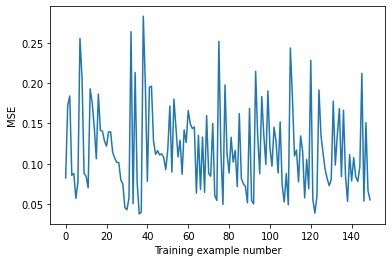


iteration 10 mse: 3.2682386254088467


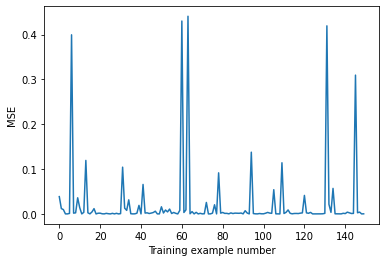


iteration 20 mse: 2.3749311391742234


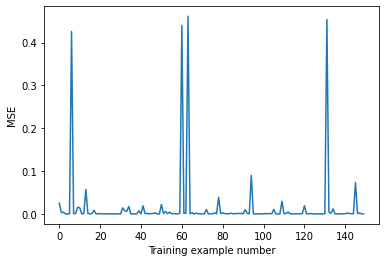


iteration 30 mse: 2.062542398149785


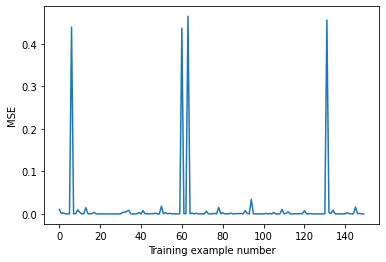


iteration 40 mse: 1.963688081271259


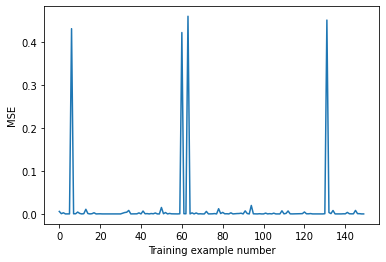


iteration 50 mse: 1.8821028486168294


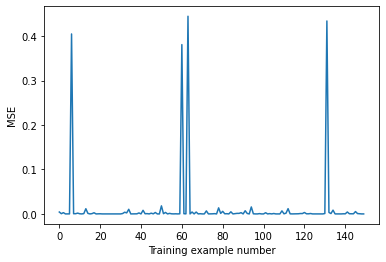


iteration 60 mse: 1.6882257836871883


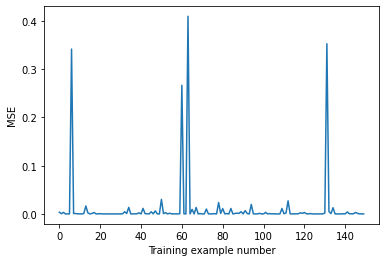


iteration 70 mse: 0.9931131376989853


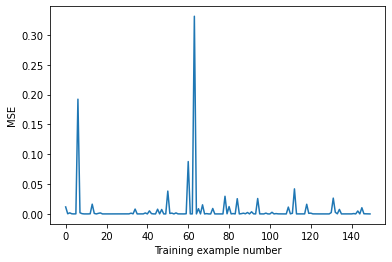


iteration 80 mse: 0.16228275031246647


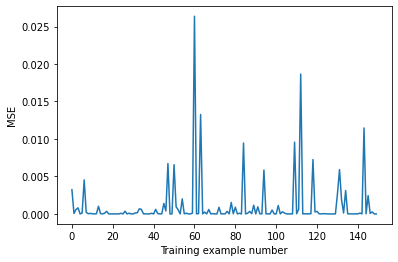


iteration 90 mse: 0.07193680962346229


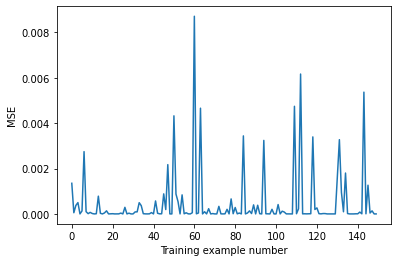


training done
Training Accuracy: 100.0


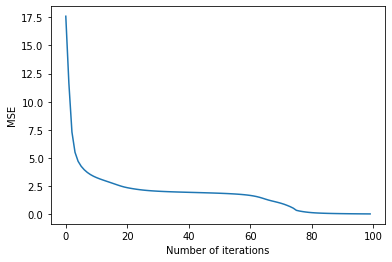

Test Accuracy: 92.0


In [ ]:
if __name__ == '__main__':

    training_data = []

    train_X = pd.read_csv("/content/drive/My Drive/Colab Notebooks/train_x.csv").to_numpy()
    train_Y = pd.read_csv("/content/drive/My Drive/Colab Notebooks/train_y.csv").to_numpy()

    m = train_X.shape[0]
    n = train_X.shape[1] - 1

    for i in range(m):
        x = train_X[i][1:]
        y = []
        y.append(train_Y[i][1])
        l = []
        l.append(x)
        l.append(y)
        training_data.append(l)
    
    
    nn = network(n, 15, 6, 1)
    nn.init_random_weights()
    mse_values = nn.back_propagation_train(training_data, 100)
    predict_data = nn.back_propagation_predict(training_data)

    accurate_results = 0
    prediction = 0

    for i in range(len(predict_data)):
        if predict_data[i][1][0] >= 0.5:
            prediction = 1
        else:
            prediction = 0
        
        if prediction == training_data[i][1][0]:
            accurate_results += 1
    
    print("Training Accuracy:", accurate_results / m * 100)

###############################################################################################################

    plt.plot(list(range(len(mse_values))), mse_values)
    plt.xlabel('Number of iterations')
    plt.ylabel('MSE')
    plt.show()

##################################################################################################################


    test_X = pd.read_csv("/content/drive/My Drive/Colab Notebooks/test_x.csv").to_numpy()
    test_Y = pd.read_csv("/content/drive/My Drive/Colab Notebooks/test_y.csv").to_numpy()
   
    test_data = []
    
    m_test = test_X.shape[0]
    n = test_X.shape[1] - 1

    for i in range(m_test):
        x_test = test_X[i][1:]
        y_test = []
        y_test.append(test_Y[i][1])
        l = []
        l.append(x_test)
        l.append(y_test)
        test_data.append(l)

    test = nn.back_propagation_predict(test_data)    
    
    accurate_results = 0
    prediction = 0

    for i in range(len(test)):
        if test[i][1][0] >= 0.5:
            prediction = 1
        else:
            prediction = 0

        if prediction == test_data[i][1][0]:
            accurate_results += 1
    
    print("Test Accuracy:", accurate_results / m_test * 100)

################################################################################### (Nilesh)

### Training using batch gradient descent

iteration 0 mse: 27.005209081944813
iteration 100 mse: 17.838883883220827
iteration 200 mse: 12.086945060293845
iteration 300 mse: 5.377983328993336
iteration 400 mse: 3.7766758777241973
iteration 500 mse: 3.1819541683242973
iteration 600 mse: 2.813398703312365
iteration 700 mse: 2.529095448748611
iteration 800 mse: 2.29772521964173
iteration 900 mse: 2.1126714578181502
training done
Training Accuracy: 98.0


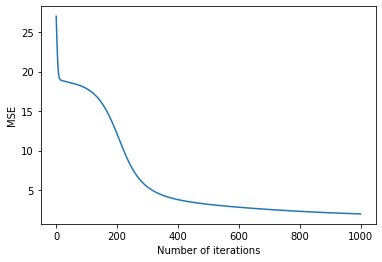

Test Accuracy: 88.0


In [ ]:
if __name__ == '__main__':

    training_data = []

    train_X = pd.read_csv("/content/drive/My Drive/Colab Notebooks/train_x.csv").to_numpy()
    train_Y = pd.read_csv("/content/drive/My Drive/Colab Notebooks/train_y.csv").to_numpy()

    m = train_X.shape[0]
    n = train_X.shape[1] - 1

    for i in range(m):
        x = train_X[i][1:]
        y = []
        y.append(train_Y[i][1])
        l = []
        l.append(x)
        l.append(y)
        training_data.append(l)
    
    
    nn = network(n, 15, 12, 6, 1)
    nn.init_random_weights()
    mse_values = nn.back_propagation_train_batch(training_data, 1000)
    predict_data = nn.back_propagation_predict(training_data)

    accurate_results = 0
    prediction = 0

    for i in range(len(predict_data)):
        if predict_data[i][1][0] >= 0.5:
            prediction = 1
        else:
            prediction = 0
        
        if prediction == training_data[i][1][0]:
            accurate_results += 1
    
    print("Training Accuracy:", accurate_results / m * 100)

#############################################################################################

    plt.plot(list(range(len(mse_values))), mse_values)
    plt.xlabel('Number of iterations')
    plt.ylabel('MSE')
    plt.show()


##################################################################################################################


    test_X = pd.read_csv("/content/drive/My Drive/Colab Notebooks/test_x.csv").to_numpy()
    test_Y = pd.read_csv("/content/drive/My Drive/Colab Notebooks/test_y.csv").to_numpy()
   
    test_data = []
    
    m_test = test_X.shape[0]
    n = test_X.shape[1] - 1

    for i in range(m_test):
        x_test = test_X[i][1:]
        y_test = []
        y_test.append(test_Y[i][1])
        l = []
        l.append(x_test)
        l.append(y_test)
        test_data.append(l)

    test = nn.back_propagation_predict(test_data)    
    
    accurate_results = 0
    prediction = 0

    for i in range(len(test)):
        if test[i][1][0] >= 0.5:
            prediction = 1
        else:
            prediction = 0

        if prediction == test_data[i][1][0]:
            accurate_results += 1
    
    print("Test Accuracy:", accurate_results / m_test * 100)


##################################################################################(Vinayak)